In [1]:
import requests
import pandas as pd
import plotly.graph_objects as go
from statsmodels.tsa.statespace.sarimax import SARIMAX
 
# --- Parámetros ---
token     = "45b0d369-41fd-467a-b7c9-6b862cf3056d"      # <— reemplaza
indicator = "910493"              # INPC general 444558 O 910424
geo       = "00000"               # Nacional (5 ceros)
fuente    = "BIE"                 # Banco de Información Económica (prueba BISE si hiciera falta)
url = (
    "https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/"
    f"INDICATOR/{indicator}/es/{geo}/false/{fuente}/2.0/{token}?type=json"
)
 
# --- Llamada API con manejo de errores legible ---
resp = requests.get(url)
if resp.status_code != 200:
    raise SystemExit(f"INEGI {resp.status_code}: {resp.text[:400]}")
 
j = resp.json()

In [2]:
# --- Graficar serie de tiempo (a partir del JSON `j`) ---

import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "browser"   # abre en navegador por defecto


# 1) Convertir JSON a DataFrame mensual
series_key = "Series" if "Series" in j else ("series" if "series" in j else None)
obs = j[series_key][0]["OBSERVATIONS"]

df = (
    pd.DataFrame(obs)[["TIME_PERIOD", "OBS_VALUE"]]
    .rename(columns={"TIME_PERIOD": "fecha", "OBS_VALUE": "valor"})
)
df["fecha"] = pd.to_datetime(df["fecha"], errors="coerce")
df["valor"] = pd.to_numeric(df["valor"], errors="coerce")
df = df.dropna().sort_values("fecha").set_index("fecha")
# asegurar frecuencia mensual (por si viniera irregular)
df = df.asfreq("MS") if df.index.inferred_freq is None else df
df = df.resample("MS").last()

# 2) Gráfica interactiva con Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=df.index, y=df["valor"],
    mode="lines",
    name="Serie observada"
))
fig.update_layout(
    title=f"Serie de tiempo — Indicador {indicator}",
    xaxis_title="Fecha",
    yaxis_title="Índice",
    hovermode="x unified",
    template="plotly_white"
)
fig.show()


/var/folders/fd/q5kbvbvd00b4rdf_lfzx0j3m0000gp/T/ipykernel_69768/3599741156.py:17: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



In [3]:
import plotly.express as px

# Filtrar desde 2015
df_2015 = df[df.index >= "2015-01-01"].copy()

# Crear columnas auxiliares para separar por año y mes
df_2015["Año"] = df_2015.index.year
df_2015["Mes"] = df_2015.index.month

# Gráfica de líneas: cada año una curva (mes en eje X)
fig = px.line(
    df_2015,
    x="Mes", y="valor",
    color="Año",
    markers=True,
    title="Comportamiento del INPC por año (2015 en adelante)"
)

fig.update_layout(
    xaxis=dict(tickmode="array", tickvals=list(range(1, 13))),
    yaxis_title="INPC",
    xaxis_title="Mes",
    legend_title="Año",
    template="plotly_white"
)

fig.show()


In [ ]:
# --- Paso 2 (alternativo): Descomposición STL para diagnosticar tendencia/estacionalidad ---

import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import STL
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.tsa.stattools import adfuller, kpss

# y: serie mensual lista (asegura frecuencia mensual y orden cronológico)
y = df["valor"].copy().sort_index()
# Normaliza a frecuencia mensual por si hiciera falta
y = y.asfreq("MS")
# (opcional) si hay pocos NaN intermensuales, puedes imputar suavemente:
# y = y.interpolate(limit_direction="both")

# Periodicidad estacional: mensual -> 12
stl = STL(y, period=12, robust=True)
res = stl.fit()

# Serie desestacionalizada (útil para justificar D=0/1)
sa = y - res.seasonal  # seasonally adjusted

# --- Gráfica interactiva con subplots ---
fig = make_subplots(
    rows=4, cols=1, shared_xaxes=True, vertical_spacing=0.04,
    subplot_titles=("Observado", "Tendencia (Trend)", "Estacionalidad (Seasonal)", "Residuo (Remainder)")
)

fig.add_trace(go.Scatter(x=y.index,  y=y.values,            name="Observado",   mode="lines"), row=1, col=1)
fig.add_trace(go.Scatter(x=y.index,  y=res.trend.values,    name="Tendencia",   mode="lines"), row=2, col=1)
fig.add_trace(go.Scatter(x=y.index,  y=res.seasonal.values, name="Estacional",  mode="lines"), row=3, col=1)
fig.add_trace(go.Scatter(x=y.index,  y=res.resid.values,    name="Residuo",     mode="lines"), row=4, col=1)

fig.update_layout(
    title="Descomposición STL (periodo=12, robust=True)",
    hovermode="x unified",
    template="plotly_white",
    height=900,
    showlegend=False
)
fig.update_xaxes(title_text="Fecha", row=4, col=1)
fig.update_yaxes(title_text="Índice", row=1, col=1)

fig.show()



Resumen STL
- Var(Estacional) / Var(Observado): 0.000
- Var(Tendencia)  / Var(Observado): 1.001
- Var(Residuo)    / Var(Observado): 0.002


In [7]:
# Prueba ADF (Augmented Dickey-Fuller)
adf_result = adfuller(y)
print("=== Prueba ADF ===")
print(f"Estadístico: {adf_result[0]:.4f}")
print(f"p-valor: {adf_result[1]:.4f}")
print("Hipótesis nula: La serie NO es estacionaria")

# Prueba KPSS
kpss_result = kpss(y, regression="c", nlags="auto")
print("\n=== Prueba KPSS ===")
print(f"Estadístico: {kpss_result[0]:.4f}")
print(f"p-valor: {kpss_result[1]:.4f}")
print("Hipótesis nula: La serie SÍ es estacionaria")

=== Prueba ADF ===
Estadístico: 0.4486
p-valor: 0.9832
Hipótesis nula: La serie NO es estacionaria

=== Prueba KPSS ===
Estadístico: 2.4160
p-valor: 0.0100
Hipótesis nula: La serie SÍ es estacionaria


/var/folders/fd/q5kbvbvd00b4rdf_lfzx0j3m0000gp/T/ipykernel_69768/3233181770.py:9: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




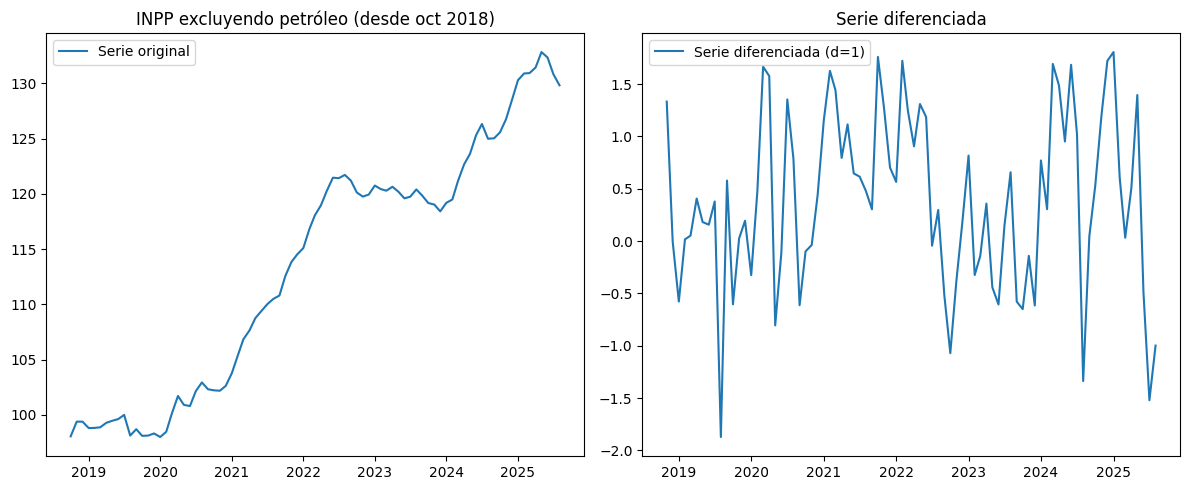

=== Prueba ADF (serie diferenciada) ===
Estadístico: -3.6251
p-valor: 0.0053
Hipótesis nula: La serie NO es estacionaria

=== Prueba KPSS (serie diferenciada) ===
Estadístico: 0.1017
p-valor: 0.1000
Hipótesis nula: La serie SÍ es estacionaria


/var/folders/fd/q5kbvbvd00b4rdf_lfzx0j3m0000gp/T/ipykernel_69768/1357466804.py:35: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




In [8]:
# --- Paso 3: Diferenciación y nueva prueba de estacionariedad ---

from statsmodels.tsa.stattools import adfuller, kpss
import matplotlib.pyplot as plt

# 1) Filtrar desde octubre 2018
y = df["valor"].copy().sort_index()
y = y[y.index >= "2018-10-01"]

# 2) Diferenciación de primer orden
y_diff = y.diff().dropna()

# 3) Graficar comparación antes/después
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(y, label="Serie original")
plt.title("INPP excluyendo petróleo (desde oct 2018)")
plt.legend()

plt.subplot(1,2,2)
plt.plot(y_diff, label="Serie diferenciada (d=1)")
plt.title("Serie diferenciada")
plt.legend()
plt.tight_layout()
plt.show()

# 4) Prueba ADF
adf_result = adfuller(y_diff)
print("=== Prueba ADF (serie diferenciada) ===")
print(f"Estadístico: {adf_result[0]:.4f}")
print(f"p-valor: {adf_result[1]:.4f}")
print("Hipótesis nula: La serie NO es estacionaria")

# 5) Prueba KPSS
kpss_result = kpss(y_diff, regression="c", nlags="auto")
print("\n=== Prueba KPSS (serie diferenciada) ===")
print(f"Estadístico: {kpss_result[0]:.4f}")
print(f"p-valor: {kpss_result[1]:.4f}")
print("Hipótesis nula: La serie SÍ es estacionaria")


Despues de la diferenciacion se obtiene de ambas pruebas la conclusion de que ya son estacionarias. 